In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from collections import defaultdict
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import block_diag
sys.path.append("../")
from mayavi import mlab
import imageio
from PIL import Image, ImageDraw, ImageFont
from torch_cluster import knn

In [33]:
def pinv(a, rrank, rcond=1e-3):
    """
    Compute the (Moore-Penrose) pseudo-inverse of a matrix.

    Calculate the generalized inverse of a matrix using its
    singular-value decomposition (SVD) and including all
    *large* singular values.

        Parameters:
            a : float[M, N]
                Matrix to be pseudo-inverted.
            rrank : int
                Maximum rank
            rcond : float, optional
                Cutoff for small singular values.
                Singular values less than or equal to
                ``rcond * largest_singular_value`` are set to zero.
                Default: ``1e-3``.

        Returns:
            B : float[N, M]
                The pseudo-inverse of `a`. 

    """
    u, s, vt = np.linalg.svd(a, full_matrices=False)

    # discard small singular values
    cutoff = rcond * s[0]
    large = s > cutoff
    large[rrank:] = False
    s = np.divide(1, s, where=large, out=s)
    s[~large] = 0

    res = np.matmul(np.transpose(vt), np.multiply(s[..., np.newaxis], np.transpose(u)))
    return res
# # def pinv(a, rrank, rcond=1e-3):
# #     """
# #     Compute the (Moore-Penrose) pseudo-inverse of a matrix.

# #     Calculate the generalized inverse of a matrix using its
# #     singular-value decomposition (SVD) and including all
# #     *large* singular values.

# #         Parameters:
# #             a : Tensor[M, N]
# #                 Matrix to be pseudo-inverted.
# #             rrank : int
# #                 Maximum rank
# #             rcond : float, optional
# #                 Cutoff for small singular values.
# #                 Singular values less than or equal to
# #                 ``rcond * largest_singular_value`` are set to zero.
# #                 Default: ``1e-3``.

# #         Returns:
# #             B : Tensor[N, M]
# #                 The pseudo-inverse of `a`.
# #     """
# #     u, s, vt = torch.linalg.svd(a, full_matrices=False)

# #     # discard small singular values
# #     cutoff = rcond * s[0]
# #     large = s > cutoff
# #     large[rrank:] = False
# #     s = torch.where(large, 1 / s, torch.zeros_like(s))

# #     res = torch.matmul(vt.T, s.unsqueeze(1) * u.T)
# #     return res
# # # def compute_edge_gradient_weights(nodes,k, rcond = 1e-3):
# # #     '''
# # #     Compute weights for gradient computation  
# # #     The gradient is computed by least square.
# # #     Node x has neighbors x1, x2, ..., xj

# # #     x1 - x                        f(x1) - f(x)
# # #     x2 - x                        f(x2) - f(x)
# # #        :      gradient f(x)     =          :
# # #        :                                :
# # #     xj - x                        f(xj) - f(x)
    
# # #     in matrix form   dx  nable f(x)   = df.
    
# # #     The pseudo-inverse of dx is pinvdx.
# # #     Then gradient f(x) for any function f, is pinvdx * df
# # #     We store directed edges (x, x1), (x, x2), ..., (x, xj)
# # #     And its associated weight pinvdx[:,1], pinvdx[:,2], ..., pinvdx[:,j]
# # #     Then the gradient can be efficiently computed with scatter_add
    
# # #     When these points are on a degerated plane or surface, the gradient towards the 
# # #     normal direction is 0.


# # #         Parameters:  
# # #             nodes : float[nnodes, ndims]
# # #                     elems : int[nelems, max_num_of_nodes_per_elem+1]. 
# # #                             The first entry is elem_dim, the dimensionality of the element.
# # #                             The elems array can have some padding numbers, for example, when
# # #                             we have both line segments and triangles, the padding values are
# # #                             -1 or any negative integers.
# # #             rcond : float, truncate the singular values in numpy.linalg.pinv at rcond*largest_singular_value
            

# # #         Return :

# # #             directed_edges : int[nedges,2]
# # #             edge_gradient_weights   : float[nedges, ndims]

# # #             * the directed_edges (and adjacent list) include all node pairs that share the element
            
# # #     '''

# # #     nnodes, ndims = nodes.shape

# # #     edge_gradient_weights = [] 
# # #     edge_sources = []
# # #     edge_dsts = []
# # #     for i in range(nnodes):
# # #         edge_source, edge_dst  = knn(nodes, nodes[i].unsqueeze(0), k = k)
# # #         dx = nodes[edge_source]-nodes[edge_dst]
# # #         edge_sources.append(edge_source)
# # #         edge_dsts.append(edge_dst)
# # #         edge_gradient_weights.append(pinv(dx, rrank=k, rcond=rcond).T)
# # #     #     elem_dim, e = elem[0], elem[1:]
# # #     #     node_dims[e] = np.maximum(node_dims[e], elem_dim)
# # #     #     e = e[e >= 0]
# # #     #     nnodes_per_elem = len(e)
# # #     #     for i in range(nnodes_per_elem):
# # #     #         # Add each node's neighbors to its set
# # #     #         adj_list[e[i]].update([e[j] for j in range(nnodes_per_elem) if j != i])
    
# # #     # directed_edges = []
# # #     # edge_gradient_weights = [] 
# # #     # for a in range(nnodes):
# # #     #     dx = np.zeros((len(adj_list[a]), ndims))
# # #     #     for i, b in enumerate(adj_list[a]):
# # #     #         dx[i, :] = nodes[b,:] - nodes[a,:]
# # #     #         directed_edges.append([a,b])
# # #     #     edge_gradient_weights.append(pinv(dx, rrank=node_dims[a], rcond=rcond).T)
        
# # #     edge_sources = np.concatenate(edge_sources, dtype=int)
# # #     edge_dsts = np.concatenate(edge_dsts, dtype=int)
# # #     directed_edges = np.vstack((edge_sources,edge_dsts)).T
# # #     edge_gradient_weights = np.concatenate(edge_gradient_weights, axis=0)
# # #     return directed_edges, edge_gradient_weights
def compute_edge_gradient_weights(nodes, k, rcond=1e-3):
    """
    Compute weights for gradient computation.
    
    Parameters:
        nodes : Tensor[nnodes, ndims]
                Coordinates of the nodes.
        k : int
            Number of nearest neighbors to consider.
        rcond : float, optional
                Cutoff for small singular values.
                Default: ``1e-3``.
    
    Returns:
        directed_edges : Tensor[nedges, 2]
                         Directed edges (source, destination).
        edge_gradient_weights : Tensor[nedges, ndims]
                                Gradient weights for each edge.
    """
    nnodes, ndims = nodes.shape
    device = nodes.device

    edge_gradient_weights = []
    edge_sources = []
    edge_dsts = []

    for i in range(nnodes):
        edge_src, edge_dst = knn(nodes, nodes[i].unsqueeze(0), k=k)
        dx = nodes[edge_dst] -nodes[edge_src]
        edge_sources.append(edge_src)
        edge_dsts.append(edge_dst)
        edge_gradient_weights.append(pinv(dx, rrank=k, rcond=rcond).T)

    edge_sources = torch.cat(edge_sources, dim=0).to(device)
    edge_dsts = torch.cat(edge_dsts, dim=0).to(device)
    directed_edges = torch.stack((edge_sources, edge_dsts), dim=1)
    edge_gradient_weights = torch.cat(edge_gradient_weights, dim=0).to(device)

    return directed_edges, edge_gradient_weights
# def pinv(a, rrank, rcond=1e-3):
#     """
#     Compute the (Moore-Penrose) pseudo-inverse of a matrix.

#     Calculate the generalized inverse of a matrix using its
#     singular-value decomposition (SVD) and including all
#     *large* singular values.

#         Parameters:
#             a : Tensor[M, N]
#                 Matrix to be pseudo-inverted.
#             rrank : int
#                 Maximum rank
#             rcond : float, optional
#                 Cutoff for small singular values.
#                 Singular values less than or equal to
#                 ``rcond * largest_singular_value`` are set to zero.
#                 Default: ``1e-3``.

#         Returns:
#             B : Tensor[N, M]
#                 The pseudo-inverse of `a`.
#     """
#     u, s, vt = torch.linalg.svd(a, full_matrices=False)

#     # discard small singular values
#     cutoff = rcond * s[0]
#     large = s > cutoff
#     large[rrank:] = False
#     s = torch.where(large, 1 / s, torch.zeros_like(s))

#     res = torch.matmul(vt.T, s.unsqueeze(1) * u.T)
#     return res

# def compute_edge_gradient_weights(nodes, k, rcond=1e-3):
#     """
#     Compute weights for gradient computation.
    
#     Parameters:
#         nodes : Tensor[nnodes, ndims]
#                 Coordinates of the nodes.
#         k : int
#             Number of nearest neighbors to consider.
#         rcond : float, optional
#                 Cutoff for small singular values.
#                 Default: ``1e-3``.
    
#     Returns:
#         directed_edges : Tensor[nedges, 2]
#                          Directed edges (source, destination).
#         edge_gradient_weights : Tensor[nedges, ndims]
#                                 Gradient weights for each edge.
#     """
#     nnodes, ndims = nodes.shape
#     device = nodes.device

#     # Compute pairwise distances
#     pairwise_distances = torch.cdist(nodes, nodes)

#     # Find the k nearest neighbors for each node
#     _, indices = torch.topk(pairwise_distances, k + 1, largest=False, dim=1)
#     indices = indices[:, 1:]  # Exclude the node itself

#     # Compute the directed edges
#     edge_sources = torch.arange(nnodes, device=device).unsqueeze(1).repeat(1, k).flatten()
#     edge_dsts = indices.flatten()

#     # Compute the difference vectors
#     dx = nodes[edge_sources] - nodes[edge_dsts]

#     # Compute the pseudo-inverse for each difference vector
#     edge_gradient_weights = []
#     for i in range(0, nnodes * k, nnodes):
#         batch_dx = dx[i:i + nnodes]
#         batch_pinv = pinv(batch_dx, rrank=k, rcond=rcond).T
#         edge_gradient_weights.append(batch_pinv)

#     edge_gradient_weights = torch.cat(edge_gradient_weights, dim=0).to(device)

#     directed_edges = torch.stack((edge_sources, edge_dsts), dim=1)

#     return directed_edges, edge_gradient_weights
# # def compute_gradient(f, directed_edges, edge_gradient_weights):
# #     '''
# #     Compute gradient of field f at each node
# #     The gradient is computed by least square.
# #     Node x has neighbors x1, x2, ..., xj

# #     x1 - x                        f(x1) - f(x)
# #     x2 - x                        f(x2) - f(x)
# #        :      gradient f(x)   =         :
# #        :                                :
# #     xj - x                        f(xj) - f(x)
    
# #     in matrix form   dx  nable f(x)   = df.
    
# #     The pseudo-inverse of dx is pinvdx.
# #     Then gradient f(x) for any function f, is pinvdx * df
# #     directed_edges stores directed edges (x, x1), (x, x2), ..., (x, xj)
# #     edge_gradient_weights stores its associated weight pinvdx[:,1], pinvdx[:,2], ..., pinvdx[:,j]

# #     Then the gradient can be computed 
# #     gradient f(x) = sum_i pinvdx[:,i] * [f(xi) - f(x)] 
# #     with scatter_add for each edge
    
    
# #         Parameters: 
# #             f : float[batch_size, in_channels, nnodes]
# #             directed_edges : int[batch_size, max_nedges, 2] 
# #             edge_gradient_weights : float[batch_size, max_nedges, ndims]
            
# #         Returns:
# #             x_gradients : float Tensor[batch_size, in_channels*ndims, max_nnodes]
# #             * in_channels*ndims dimension is gradient[x_1], gradient[x_2], gradient[x_3]......
# #     '''

# #     f = f.permute(0,2,1)
# #     batch_size, max_nnodes, in_channels = f.shape
# #     _, max_nedges, ndims = edge_gradient_weights.shape
# #     # Message passing : compute message = edge_gradient_weights * (f_source - f_target) for each edge
# #     # target\source : int Tensor[batch_size, max_nedges]
# #     # message : float Tensor[batch_size, max_nedges, in_channels*ndims]

# #     target, source = directed_edges[...,0], directed_edges[...,1]  # source and target nodes of edges
# #     message = torch.einsum('bed,bec->becd', edge_gradient_weights, f[torch.arange(batch_size).unsqueeze(1), source] - f[torch.arange(batch_size).unsqueeze(1), target]).reshape(batch_size, max_nedges, in_channels*ndims)
    
# #     # f_gradients : float Tensor[batch_size, max_nnodes, in_channels*ndims]
# #     f_gradients = torch.zeros(batch_size, max_nnodes, in_channels*ndims, dtype=message.dtype, device=message.device)
# #     f_gradients.scatter_add_(dim=1,  src=message, index=target.unsqueeze(2).repeat(1,1,in_channels*ndims))
    
# #     return f_gradients.permute(0,2,1)

# def compute_gradient(f, directed_edges, edge_gradient_weights):
#     """
#     Compute gradient of field f at each node.
    
#     Parameters:
#         f : Tensor[batch_size, in_channels, nnodes]
#             Field values at each node.
#         directed_edges : Tensor[max_nedges, 2]
#                          Directed edges (source, destination).
#         edge_gradient_weights : Tensor[max_nedges, ndims]
#                                 Gradient weights for each edge.
    
#     Returns:
#         f_gradients : Tensor[batch_size, in_channels*ndims, max_nnodes]
#                       Gradients of the field at each node.
#     """
#     f = f.permute(0, 2, 1)
#     batch_size, max_nnodes, in_channels = f.shape
#     max_nedges, ndims = edge_gradient_weights.shape
#     device = f.device

#     target, source = directed_edges[..., 0], directed_edges[..., 1]
    
#     # Ensure the indices are on the same device as f
#     batch_indices = torch.arange(batch_size, device=device).unsqueeze(1)
    
#     # Repeat edge_gradient_weights and directed_edges for each batch
#     edge_gradient_weights_batch = edge_gradient_weights.unsqueeze(0).repeat(batch_size, 1, 1)
#     directed_edges_batch = directed_edges.unsqueeze(0).repeat(batch_size, 1, 1)
    
#     message = torch.einsum('bed,bec->becd', edge_gradient_weights_batch, f[batch_indices, source] - f[batch_indices, target]).reshape(batch_size, max_nedges, in_channels * ndims)

#     f_gradients = torch.zeros(batch_size, max_nnodes, in_channels * ndims, dtype=message.dtype, device=device)
#     f_gradients.scatter_add_(dim=1, index=directed_edges_batch[..., 0].unsqueeze(2).repeat(1, 1, in_channels * ndims), src=message)

#     return f_gradients.permute(0, 2, 1)

In [34]:
def compute_gradient(f, directed_edges, edge_gradient_weights):
    '''
    Compute gradient of field f at each node
    The gradient is computed by least square.
    Node x has neighbors x1, x2, ..., xj

    x1 - x                        f(x1) - f(x)
    x2 - x                        f(x2) - f(x)
       :      gradient f(x)   =         :
       :                                :
    xj - x                        f(xj) - f(x)
    
    in matrix form   dx  nable f(x)   = df.
    
    The pseudo-inverse of dx is pinvdx.
    Then gradient f(x) for any function f, is pinvdx * df
    directed_edges stores directed edges (x, x1), (x, x2), ..., (x, xj)
    edge_gradient_weights stores its associated weight pinvdx[:,1], pinvdx[:,2], ..., pinvdx[:,j]

    Then the gradient can be computed 
    gradient f(x) = sum_i pinvdx[:,i] * [f(xi) - f(x)] 
    with scatter_add for each edge
    
    
        Parameters: 
            f : float[batch_size, in_channels, nnodes]
            directed_edges : int[batch_size, max_nedges, 2] 
            edge_gradient_weights : float[batch_size, max_nedges, ndims]
            
        Returns:
            x_gradients : float Tensor[batch_size, in_channels*ndims, max_nnodes]
            * in_channels*ndims dimension is gradient[x_1], gradient[x_2], gradient[x_3]......
    '''

    f = f.permute(0,2,1)
    batch_size, max_nnodes, in_channels = f.shape
    _, max_nedges, ndims = edge_gradient_weights.shape
    # Message passing : compute message = edge_gradient_weights * (f_source - f_target) for each edge
    # target\source : int Tensor[batch_size, max_nedges]
    # message : float Tensor[batch_size, max_nedges, in_channels*ndims]

    target, source = directed_edges[...,0], directed_edges[...,1]  # source and target nodes of edges
    message = torch.einsum('bed,bec->becd', edge_gradient_weights, f[torch.arange(batch_size).unsqueeze(1), source] - f[torch.arange(batch_size).unsqueeze(1), target]).reshape(batch_size, max_nedges, in_channels*ndims)
    
    # f_gradients : float Tensor[batch_size, max_nnodes, in_channels*ndims]
    f_gradients = torch.zeros(batch_size, max_nnodes, in_channels*ndims, dtype=message.dtype, device=message.device)
    f_gradients.scatter_add_(dim=1,  src=message, index=target.unsqueeze(2).repeat(1,1,in_channels*ndims))
    
    return f_gradients.permute(0,2,1)

torch.Size([900, 2])


C:\Users\15461\AppData\Local\Temp\ipykernel_22444\3417736850.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = np.matmul(np.transpose(vt), np.multiply(s[..., np.newaxis], np.transpose(u)))


torch.Size([10, 128, 2, 900])


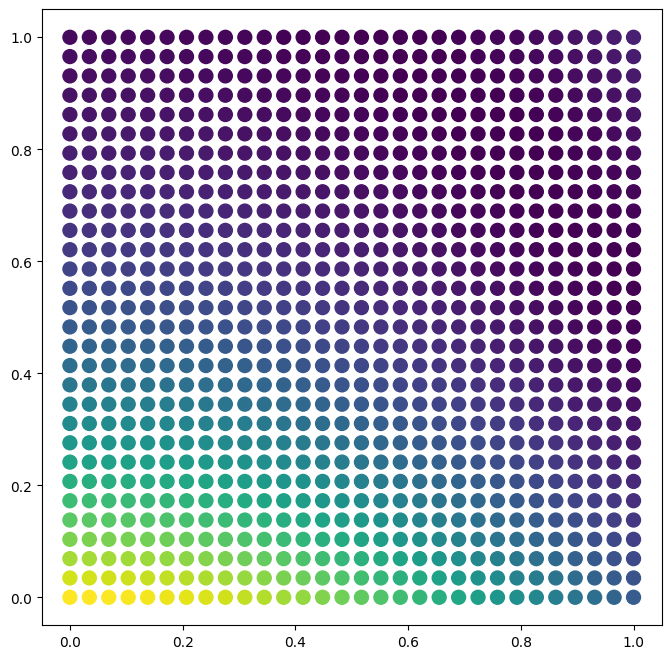

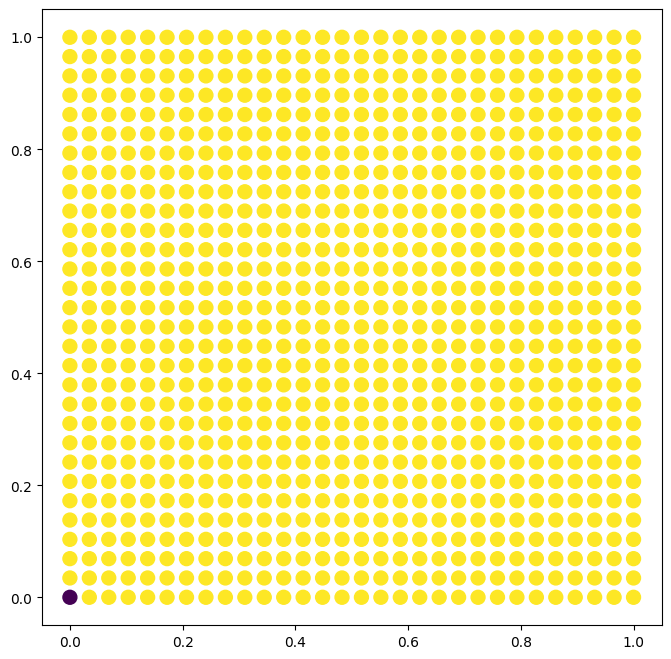

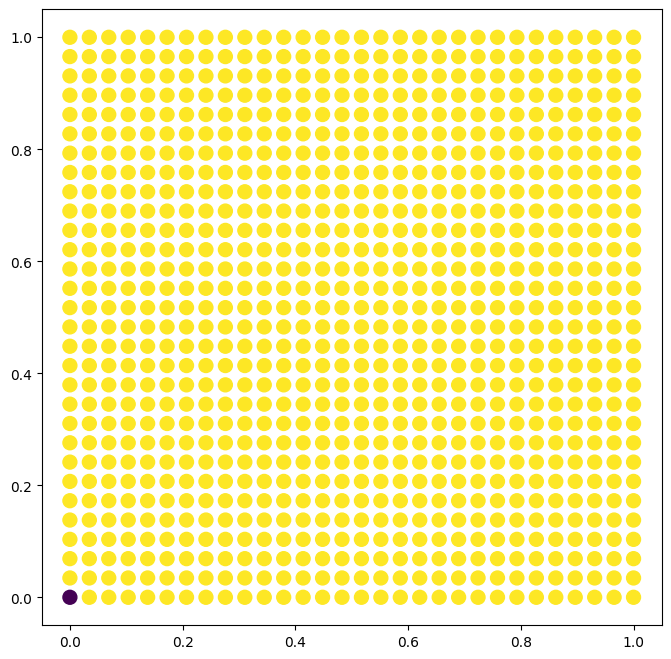

In [ ]:
import matplotlib.pyplot as plt
N = 30
x ,y= torch.linspace(0,1,N),torch.linspace(0,1,N)

X,Y = torch.meshgrid(x,y)
x_coords = X.reshape(-1)
y_coords = Y.reshape(-1)
nodes = torch.cat((x_coords.reshape(-1,1),y_coords.reshape(-1,1)),dim = -1).to('cpu')
print(nodes.shape)

k = 1
bsz = 10
channel = 128
f = (100*(torch.cos(nodes[:,0]) - torch.sin(nodes[:,1]))**2).reshape(1,1,-1).repeat(bsz,channel,1)
plt.figure(figsize=(8, 8))
plt.scatter(x_coords.cpu(), y_coords.cpu(), c=f[0,0].cpu(), cmap='viridis', s=100)
# for _ in range(100):

directed_edges, edge_gradient_weights = compute_edge_gradient_weights(nodes,k, rcond = 1e-3)
directed_edges = directed_edges.unsqueeze(0).repeat(bsz,1,1)
edge_gradient_weights = edge_gradient_weights.unsqueeze(0).repeat(bsz,1,1)
# print(directed_edges.shape,edge_gradient_weights.shape)

f_gradient = compute_gradient(f, directed_edges, edge_gradient_weights)
f_gradient = f_gradient.reshape(bsz,channel,2,N**2)
print(f_gradient.shape)
plt.figure(figsize=(8, 8))
plt.scatter(x_coords.cpu(), y_coords.cpu(), c=f_gradient[0,0,1,:].cpu(), cmap='viridis', s=100)
plt.figure(figsize=(8, 8))
plt.scatter(x_coords.cpu(), y_coords.cpu(), c=f_gradient[0,0,0,:].cpu(), cmap='viridis', s=100)